# Cam2BEV using UNetXST

GitHub: https://github.com/ika-rwth-aachen/Cam2BEV

Paper: https://arxiv.org/abs/2005.04078

# Utility Functions

In [1]:
import os
import sys
import numpy as np
import random
import tensorflow as tf
import cv2
from tqdm import tqdm


def get_files_in_folder(folder):
    return sorted([os.path.join(folder, f) for f in os.listdir(folder)])

def sample_list(*ls, n_samples, replace=False):
    n_samples = min(len(ls[0]), n_samples)
    idcs = np.random.choice(np.arange(0, len(ls[0])), n_samples, replace=replace)
    samples = zip([np.take(l, idcs) for l in ls])
    return samples, idcs

def load_image(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_image_op(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    return img

def resize_image(img, shape, interpolation=cv2.INTER_CUBIC):
    # resize relevant image axis to length of corresponding target axis while preserving aspect ratio
    axis = 0 if float(shape[0]) / float(img.shape[0]) > float(shape[1]) / float(img.shape[1]) else 1
    factor = float(shape[axis]) / float(img.shape[axis])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor, interpolation=interpolation)

    # crop other image axis to match target shape
    center = img.shape[int(not axis)] / 2.0
    step = shape[int(not axis)] / 2.0
    left = int(center-step)
    right = int(center+step)
    if axis == 0:
        img = img[:, left:right]
    else:
        img = img[left:right, :]

    return img

def resize_image_op(img, fromShape, toShape, cropToPreserveAspectRatio=True, interpolation=tf.image.ResizeMethod.BICUBIC):
    if not cropToPreserveAspectRatio:
        img = tf.image.resize(img, toShape, method=interpolation)

    else:
        # first crop to match target aspect ratio
        fx = toShape[1] / fromShape[1]
        fy = toShape[0] / fromShape[0]
        relevantAxis = 0 if fx < fy else 1
        if relevantAxis == 0:
            crop = fromShape[0] * toShape[1] / toShape[0]
            img = tf.image.crop_to_bounding_box(img, 0, int((fromShape[1] - crop) / 2), fromShape[0], int(crop))
        else:
            crop = fromShape[1] * toShape[0] / toShape[1]
            img = tf.image.crop_to_bounding_box(img, int((fromShape[0] - crop) / 2), 0, int(crop), fromShape[1])

        # then resize to target shape
        img = tf.image.resize(img, toShape, method=interpolation)

    return img


def one_hot_encode_image(image, palette):
    one_hot_map = []

    # find instances of class colors and append layer to one-hot-map
    for class_colors in palette:
        class_map = np.zeros(image.shape[0:2], dtype=bool)
        for color in class_colors:
            class_map = class_map | (image == color).all(axis=-1)
        one_hot_map.append(class_map)

    # finalize one-hot-map
    one_hot_map = np.stack(one_hot_map, axis=-1)
    one_hot_map = one_hot_map.astype(np.float32)

    return one_hot_map


def one_hot_encode_image_op(image, palette):
    one_hot_map = []

    for class_colors in palette:

        class_map = tf.zeros(image.shape[0:2], dtype=tf.int32)

        for color in class_colors:
            # find instances of color and append layer to one-hot-map
            class_map = tf.bitwise.bitwise_or(class_map, tf.cast(tf.reduce_all(tf.equal(image, color), axis=-1), tf.int32))
        one_hot_map.append(class_map)

    # finalize one-hot-map
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)

    return one_hot_map


def one_hot_decode_image(one_hot_image, palette):
    # create empty image with correct dimensions
    height, width = one_hot_image.shape[0:2]
    depth = palette[0][0].size
    image = np.zeros([height, width, depth])

    # reduce all layers of one-hot-encoding to one layer with indices of the classes
    map_of_classes = one_hot_image.argmax(2)

    for idx, class_colors in enumerate(palette):
        # fill image with corresponding class colors
        image[np.where(map_of_classes == idx)] = class_colors[0]

    image = image.astype(np.uint8)

    return image

def get_class_distribution(folder, shape, palette):
    # get filepaths
    files = [os.path.join(folder, f) for f in os.listdir(folder) if not f.startswith(".")]

    n_classes = len(palette)

    def get_img(file, shape, interpolation=cv2.INTER_NEAREST, one_hot_reduce=False):
        img = load_image(file)
        img = resize_image(img, shape, interpolation)
        img = one_hot_encode_image(img, palette)
        return img

    px = shape[0] * shape[1]

    distribution = {}
    for k in range(n_classes):
        distribution[str(k)] = 0

    i = 0
    bar = tqdm(files)
    for f in bar:
        img = get_img(f, shape)
        classes = np.argmax(img, axis=-1)
        unique, counts = np.unique(classes, return_counts=True)
        occs = dict(zip(unique, counts))

        for k in range(n_classes):
            occ = occs[k] if k in occs.keys() else 0
            distribution[str(k)] = (distribution[str(k)] * i + occ / px) / (i+1)

        bar.set_postfix(distribution)

        i += 1

    return distribution


def weighted_categorical_crossentropy(weights):
    def wcce(y_true, y_pred):
        Kweights = tf.constant(weights)
        if not tf.is_tensor(y_pred): y_pred = tf.constant(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.keras.backend.categorical_crossentropy(y_true, y_pred) * tf.keras.backend.sum(y_true * Kweights, axis=-1)

    return wcce


class MeanIoUWithOneHotLabels(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Configuration

In [2]:
from easydict import EasyDict as edict

TRAIN_PATH = '../input/semantic-segmentation-bev/cam2bev-data-master-1_FRLR/1_FRLR/train/'
VAL_PATH = '../input/semantic-segmentation-bev/cam2bev-data-master-1_FRLR/1_FRLR/val/'
configs = {
    "input_training": [TRAIN_PATH + 'front/front/', TRAIN_PATH + 'rear/rear/', TRAIN_PATH + 'left/left/', TRAIN_PATH + '/right/right/'],
    "label_training": TRAIN_PATH + 'bev+occlusion/bev+occlusion/',
    "max_samples_training": 10000,
    "input_validation": [VAL_PATH + 'front/front/', VAL_PATH + 'rear/rear/', VAL_PATH + 'left/left/', VAL_PATH + '/right/right/'],
    "label_validation": VAL_PATH + 'bev+occlusion/bev+occlusion/',
    "input_testing": [VAL_PATH + 'front/front/', VAL_PATH + 'rear/rear/', VAL_PATH + 'left/left/', VAL_PATH + '/right/right/'],
    "label_testing": VAL_PATH + 'bev+occlusion/bev+occlusion/',
    "max_samples_validation": 10000,
    "max_samples_testing": 10000,
    "image_shape": [128, 256],
    "epochs": 20,
    "batch_size": 64,
    "learning_rate": 1e-4,
    "loss_weights": [0.98684351, 2.2481491, 10.47452063, 4.78351389, 7.01028204, 8.41360361, 10.91633349, 2.38571558, 1.02473193, 2.79359197],
    "early_stopping_patience": 20,
    "save_interval": 5,
    "output_dir": "output"
}

conf = edict(configs)

In [3]:
# Palette Configuration for identifying classes based on colors
conf.one_hot_palette_input = np.array([
    np.array([[128, 64, 128]]),
    np.array([[244, 35, 232], [250, 170, 160]]),
    np.array([[255, 0, 0]]),
    np.array([[0, 0, 142], [0, 0, 110]]),
    np.array([[0, 0, 70]]),
    np.array([[0, 60, 100], [0, 0, 90]]),
    np.array([[220, 20, 60], [0, 0, 230], [119, 11, 32]]),
    
    np.array([[0, 0, 0], [111, 74, 0], [81, 0, 81], [230, 150, 140], [70, 70, 70],
     [102, 102, 156], [190, 153, 153], [180, 165, 180], [150, 100, 100],
     [150, 120, 90], [153, 153, 153], [153, 153, 153], [250, 170, 30],
     [220, 220, 0], [0, 80, 100]]),
    
    np.array([[107, 142, 35], [152, 251, 152]]),
    np.array([[70, 130, 180]])
])

conf.one_hot_palette_label = np.array([
    np.array([[128, 64, 128]]),
    np.array([[244, 35, 232], [250, 170, 160]]),
    np.array([[255, 0, 0]]),
    np.array([[0, 0, 142], [0, 0, 110]]),
    np.array([[0, 0, 70]]),
    np.array([[0, 60, 100], [0, 0, 90]]),
    np.array([[220, 20, 60], [0, 0, 230], [119, 11, 32]]),
    
    np.array([[0, 0, 0], [111, 74, 0], [81, 0, 81], [230, 150, 140], [70, 70, 70],
     [102, 102, 156], [190, 153, 153], [180, 165, 180], [150, 100, 100],
     [150, 120, 90], [153, 153, 153], [153, 153, 153], [250, 170, 30],
     [220, 220, 0], [0, 80, 100], [70, 130, 180]]),
    
    np.array([[107, 142, 35], [152, 251, 152]]),
    np.array([[150, 150, 150]])
])

n_classes_input = len(conf.one_hot_palette_input)
n_classes_label = len(conf.one_hot_palette_label)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
import numpy as np

# Homography Matrix for dataset
H = [
  np.array([[4.651574574230558e-14, 10.192351107009959, -5.36318723862984e-07], [-5.588661045867985e-07, 0.0, 2.3708767903941617], [35.30731833118676, 0.0, -1.7000018578614013]]),                                       # front
  np.array([[-5.336674306912119e-14, -10.192351107009957, 5.363187220578325e-07], [5.588660952931949e-07, 3.582264351370481e-23, 2.370876772982613], [-35.30731833118661, -2.263156574813233e-15, -0.5999981421386035]]), # rear
  np.array([[20.38470221401992, 7.562206982469407e-14, -0.28867638384075833], [-3.422067857504854e-23, 2.794330463189411e-07, 2.540225111648729], [2.1619497190382224e-15, -17.65365916559334, -0.4999990710692976]]),    # left
  np.array([[-20.38470221401991, -4.849709834037436e-15, 0.2886763838407495], [-3.4220679184765114e-23, -2.794330512976549e-07, 2.5402251116487626], [2.161949719038217e-15, 17.653659165593304, -0.5000009289306967]])   # right
]

In [5]:
# get max_samples_training random training samples
n_inputs = len(conf.input_training)
files_train_input = [get_files_in_folder(folder) for folder in conf.input_training]
files_train_label = get_files_in_folder(conf.label_training)
_, idcs = sample_list(files_train_label, n_samples=conf.max_samples_training)
files_train_input = [np.take(f, idcs) for f in files_train_input]
files_train_label = np.take(files_train_label, idcs)
image_shape_original_input = load_image(files_train_input[0][0]).shape[0:2]
image_shape_original_label = load_image(files_train_label[0]).shape[0:2]
print(f"Found {len(files_train_label)} training samples")

# get max_samples_validation random validation samples
files_valid_input = [get_files_in_folder(folder) for folder in conf.input_validation]
files_valid_label = get_files_in_folder(conf.label_validation)
_, idcs = sample_list(files_valid_label, n_samples=conf.max_samples_validation)
files_valid_input = [np.take(f, idcs) for f in files_valid_input]
files_valid_label = np.take(files_valid_label, idcs)
print(f"Found {len(files_valid_label)} validation samples")

Found 10000 training samples
Found 3731 validation samples


# Data Loader

In [6]:
# build dataset pipeline parsing functions
def parse_sample(input_files, label_file):
    # parse and process input images
    inputs = []
    for inp in input_files:
        inp = load_image_op(inp)
        inp = resize_image_op(inp, image_shape_original_input, conf.image_shape, interpolation=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        inp = one_hot_encode_image_op(inp, conf.one_hot_palette_input)
        inputs.append(inp)
    inputs = inputs[0] if n_inputs == 1 else tuple(inputs)
    # parse and process label image
    label = load_image_op(label_file)
    label = resize_image_op(label, image_shape_original_label, conf.image_shape, interpolation=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = one_hot_encode_image_op(label, conf.one_hot_palette_label)
    return inputs, label

# build training data pipeline
dataTrain = tf.data.Dataset.from_tensor_slices((tuple(files_train_input), files_train_label))
dataTrain = dataTrain.shuffle(buffer_size=conf.max_samples_training, reshuffle_each_iteration=True)
dataTrain = dataTrain.map(parse_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataTrain = dataTrain.batch(conf.batch_size, drop_remainder=True)
dataTrain = dataTrain.repeat(conf.epochs)
dataTrain = dataTrain.prefetch(1)
print("Built data pipeline for training")

# build validation data pipeline
dataValid = tf.data.Dataset.from_tensor_slices((tuple(files_valid_input), files_valid_label))
dataValid = dataValid.map(parse_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataValid = dataValid.batch(1)
dataValid = dataValid.repeat(conf.epochs)
dataValid = dataValid.prefetch(1)
print("Built data pipeline for validation")

2021-12-17 05:25:07.258908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 05:25:07.350053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 05:25:07.350993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 05:25:07.353597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Built data pipeline for training
Built data pipeline for validation


# Network Architecture

## Spatial Transformer

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Activation, MaxPooling2D, Flatten, Conv2D, Dense, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def K_meshgrid(x, y):
    return tf.meshgrid(x, y)


def K_linspace(start, stop, num):
    return tf.linspace(start, stop, num)


class BilinearInterpolation(Layer):
    """Performs bilinear interpolation as a keras layer
    References
    ----------
    [1]  Spatial Transformer Networks, Max Jaderberg, et al.
    [2]  https://github.com/skaae/transformer_network
    [3]  https://github.com/EderSantana/seya
    """

    def __init__(self, output_size, **kwargs):
        self.output_size = output_size
        super(BilinearInterpolation, self).__init__(**kwargs)

    def get_config(self):
        return {
            'output_size': self.output_size,
        }

    def compute_output_shape(self, input_shapes):
        height, width = self.output_size
        num_channels = input_shapes[0][-1]
        return (None, height, width, num_channels)

    def call(self, tensors, mask=None):
        X, transformation = tensors
        output = self._transform(X, transformation, self.output_size)
        return output

    def _interpolate(self, image, sampled_grids, output_size):

        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d
        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = K_linspace(-1., 1., width)
        y_linspace = K_linspace(-1., 1., height)
        x_coordinates, y_coordinates = K_meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))
        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, transformation, output_size):
        
        batch_size, num_channels = K.shape(X)[0], X.shape[3]

        transformation = K.reshape(transformation, shape=(batch_size, 3, 3))

        # create regular grid (-1,1)x(-1,1)
        regular_grids = self._make_regular_grids(batch_size, *output_size)

        # transform regular grid
        sampled_grids = K.batch_dot(transformation, regular_grids)

        # homogeneous coords: divide by 3rd component w
        w = tf.math.reciprocal(sampled_grids[:, 2, :])
        w = tf.reshape(w, (batch_size, 1, w.shape[-1]))
        w = tf.tile(w, [1, 2, 1])
        sampled_grids = Multiply()([sampled_grids[:, 0:2, :], w])

        # interpolate image
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)

        return interpolated_image


def STN_example_model(input_shape=(60, 60, 1), sampling_size=(30, 30), num_classes=10):

    image = Input(shape=input_shape)
    locnet = MaxPooling2D(pool_size=(2, 2))(image)
    locnet = Conv2D(20, (5, 5))(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(20, (5, 5))(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    def get_initial_weights(output_size):
        b = np.zeros((2, 3), dtype='float32')
        b[0, 0] = 1
        b[1, 1] = 1
        W = np.zeros((output_size, 6), dtype='float32')
        weights = [W, b.flatten()]
        return weights
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([image, locnet])
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    return Model(inputs=image, outputs=x)


def _spatial_transformer(input, output_shape, theta_init=np.eye(3), theta_const=False, loc_downsample=3, dense_units=20, filters=16, kernel_size=(3,3), activation=tf.nn.relu, dense_reg=0.0):

    theta_init = theta_init.flatten().astype(np.float32)

    if not theta_const:

        t = input

        # initialize transform to identity
        init_weights = [np.zeros((dense_units, 9), dtype=np.float32), theta_init]

        # localization network
        for d in range(loc_downsample):
            t = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", activation=activation)(t)
            t = MaxPooling2D(pool_size=(2,2), padding="same")(t)
        t = Flatten()(t)
        t = Dense(dense_units)(t)

        k_reg = tf.keras.regularizers.l2(dense_reg) if dense_reg > 0 else None
        b_reg = tf.keras.regularizers.l2(dense_reg) if dense_reg > 0 else None
        theta = Dense(9, weights=init_weights, kernel_regularizer=k_reg, bias_regularizer=b_reg)(t) # transformation parameters

    else:

        theta = tf.tile(theta_init, tf.shape(input)[0:1])

    # transform feature map
    output = BilinearInterpolation(output_shape)([input, theta])

    return output


def SpatialTransformer(input_shape, output_shape, theta_init=np.eye(3), theta_const=False, loc_downsample=3, dense_units=20, filters=16, kernel_size=(3,3), activation=tf.nn.relu, dense_reg=0.0):

    input = Input(input_shape)
    output = _spatial_transformer(input, output_shape[0:2], theta_init, theta_const, loc_downsample, dense_units, filters, kernel_size, activation, dense_reg)

    return Model(input, output)

## UNetXST

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate


def encoder(input, udepth=3, filters1=8, kernel_size=(3,3), activation=tf.nn.relu, batch_norm=True, dropout=0.1):

    t = input
    encoder_layers = udepth * [None]

    # common parameters
    pool_size = (2,2)
    padding = "same"

    # layer creation with successive pooling
    for d in range(udepth):
        filters = (2**d) * filters1
        t = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(t)
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=pool_size, padding=padding)(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers


def joiner(list_of_encoder_layers, thetas, filters1=8, kernel_size=(3,3), activation=tf.nn.relu, batch_norm=True, double_skip_connection=False):

    n_inputs = len(list_of_encoder_layers)
    udepth = len(list_of_encoder_layers[0])
    encoder_layers = udepth * [None]

    for d in range(udepth):
        filters = (2**d) * filters1
        shape = list_of_encoder_layers[0][d].shape[1:]

        warped_maps = []
        for i in range(n_inputs): # use Spatial Transformer with constant homography transformation before concatenating
            # Problem w/ trainable theta: regularization necessary, huge loss, always went to loss=nan
            t = SpatialTransformer(shape, shape, theta_init=thetas[i], theta_const=True)(list_of_encoder_layers[i][d])
            warped_maps.append(t)
        t = Concatenate()(warped_maps) if n_inputs > 1 else warped_maps[0]
        t = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", activation=activation)(t)
        t = warped = BatchNormalization()(t) if batch_norm else t

        if not double_skip_connection:

            t = encoder_layers[d] = warped

        else:

            nonwarped_maps = []
            for i in range(n_inputs): # also concat non-warped maps
                t = list_of_encoder_layers[i][d]
                nonwarped_maps.append(t)
            t = Concatenate()(nonwarped_maps) if n_inputs > 1 else nonwarped_maps[0]
            t = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", activation=activation)(t)
            t = BatchNormalization()(t) if batch_norm else t
            t = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", activation=activation)(t)
            t = nonwarped = BatchNormalization()(t) if batch_norm else t

            # concat both
            t = Concatenate()([warped, nonwarped])
            t = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", activation=activation)(t)
            t = BatchNormalization()(t) if batch_norm else t
            t = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", activation=activation)(t)
            t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t

    return encoder_layers


def decoder(encoder_layers, udepth=3, filters1=8, kernel_size=(3,3), activation=tf.nn.relu, batch_norm=True, dropout=0.1):

    # start at lowest encoder layer
    t = encoder_layers[udepth-1]

    # common parameters
    strides = (2,2)
    padding = "same"

    # layer expansion symmetric to encoder
    for d in reversed(range(udepth-1)):
        filters = (2**d) * filters1
        t = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(t)
        t = Concatenate()([encoder_layers[d], t])
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        t = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t

    return t


def get_network(input_shape, n_output_channels, n_inputs, thetas, 
                udepth = 5, 
                filters1 = 16, 
                kernel_size = (3,3), 
                activation = tf.nn.relu, 
                batch_norm = True, 
                dropout = 0.1,
                double_skip_connection = False):

    # build inputs
    inputs = [Input(input_shape) for i in range(n_inputs)]

    # encode all inputs separately
    list_of_encoder_layers = []
    for i in inputs:
        encoder_layers = encoder(i, udepth, filters1, kernel_size, activation, batch_norm, dropout)
        list_of_encoder_layers.append(encoder_layers)

    # fuse encodings of all inputs at all layers
    encoder_layers = joiner(list_of_encoder_layers, thetas, filters1, kernel_size, activation, batch_norm, double_skip_connection)

    # decode from bottom to top layer
    reconstruction = decoder(encoder_layers, udepth, filters1, kernel_size, activation, batch_norm, dropout)

    # build final prediction layer
    prediction = Conv2D(filters=n_output_channels, kernel_size=kernel_size, padding="same", activation=activation)(reconstruction)
    prediction = Activation("softmax")(prediction)

    return Model(inputs, prediction)

## Build Model

In [9]:
model = get_network((conf.image_shape[0], conf.image_shape[1], n_classes_input), n_classes_label, n_inputs=n_inputs, thetas=H)
optimizer = tf.keras.optimizers.Adam(learning_rate=conf.learning_rate)
loss = weighted_categorical_crossentropy(conf.loss_weights)

metrics = [tf.keras.metrics.CategoricalAccuracy(), MeanIoUWithOneHotLabels(num_classes=n_classes_label)]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(f"Compiled model")

Compiled model


# Train

In [10]:
from datetime import datetime
now_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [11]:
# create output directories
model_output_dir = os.path.join(conf.output_dir, now_time)
tensorboard_dir = os.path.join(model_output_dir, "TensorBoard")
checkpoint_dir  = os.path.join(model_output_dir, "Checkpoints")
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


# create callbacks to be called after each epoch
n_batches_train = len(files_train_label) // conf.batch_size
n_batches_valid = len(files_valid_label)
tensorboard_cb      = tf.keras.callbacks.TensorBoard(tensorboard_dir, update_freq="epoch", profile_batch=0)
checkpoint_cb       = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, "e{epoch:03d}_weights.hdf5"), save_freq=n_batches_train*conf.save_interval, save_weights_only=True)
best_checkpoint_cb  = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, "best_weights.hdf5"), save_best_only=True, monitor="val_mean_io_u_with_one_hot_labels", mode="max", save_weights_only=True)
early_stopping_cb   = tf.keras.callbacks.EarlyStopping(monitor="val_mean_io_u_with_one_hot_labels", mode="max", patience=conf.early_stopping_patience, verbose=1)
callbacks = [tensorboard_cb, checkpoint_cb, best_checkpoint_cb, early_stopping_cb]

In [12]:
# Retraining for better performance
# These weights are from a previous training
model.load_weights('../input/temporary/best_weights.hdf5')
print(f"Reloaded weights")

Reloaded weights


In [13]:
print("Starting training...")
model.fit(dataTrain,
          epochs=conf.epochs, steps_per_epoch=n_batches_train,
          validation_data=dataValid, validation_freq=1, validation_steps=n_batches_valid,
          callbacks=callbacks)

Starting training...


2021-12-17 05:25:27.977977: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-17 05:26:05.701780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


156/156 [==============================] - 1792s 11s/step - loss: 0.2432 - categorical_accuracy: 0.9538 - mean_io_u_with_one_hot_labels: 0.6070 - val_loss: 0.2439 - val_categorical_accuracy: 0.9533 - val_mean_io_u_with_one_hot_labels: 0.5789
Epoch 2/20
156/156 [==============================] - 1619s 10s/step - loss: 0.2224 - categorical_accuracy: 0.9567 - mean_io_u_with_one_hot_labels: 0.6242 - val_loss: 0.2449 - val_categorical_accuracy: 0.9522 - val_mean_io_u_with_one_hot_labels: 0.5806
Epoch 3/20
156/156 [==============================] - 1604s 10s/step - loss: 0.2120 - categorical_accuracy: 0.9582 - mean_io_u_with_one_hot_labels: 0.6330 - val_loss: 0.2366 - val_categorical_accuracy: 0.9538 - val_mean_io_u_with_one_hot_labels: 0.5915
Epoch 4/20
156/156 [==============================] - 1545s 10s/step - loss: 0.2039 - categorical_accuracy: 0.9592 - mean_io_u_with_one_hot_labels: 0.6383 - val_loss: 0.2397 - val_categorical_accuracy: 0.9534 - val_mean_io_u_with_one_hot_labels: 0.5945

# Testing

In [14]:
conf.model_weights = os.path.join(checkpoint_dir, 'best_weights.hdf5') 
conf.prediction_dir = os.path.join(model_output_dir, 'Predictions')
if not os.path.exists(conf.prediction_dir):
    os.makedirs(conf.prediction_dir)

In [15]:
# get max_samples_testing samples
files_input = [get_files_in_folder(folder) for folder in conf.input_testing]
files_label = get_files_in_folder(conf.label_testing)
_, idcs = sample_list(files_input[0], n_samples=conf.max_samples_testing)
files_input = [np.take(f, idcs) for f in files_input]
files_label = np.take(files_label, idcs)

n_inputs = len(conf.input_testing)
n_samples = len(files_input[0])
image_shape_original = load_image(files_input[0][0]).shape[0:2]
image_shape_original_label = load_image(files_label[0]).shape[0:2]

print(f"Found {n_samples} samples")

# build data parsing function
def parse_sample(input_files):
    # parse and process input images
    inputs = []
    for inp in input_files:
        inp = load_image_op(inp)
        inp = resize_image_op(inp, image_shape_original, conf.image_shape, interpolation=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        inp = one_hot_encode_image_op(inp, conf.one_hot_palette_input)
        inputs.append(inp)
    inputs = inputs[0] if n_inputs == 1 else tuple(inputs)
    return inputs

Found 3731 samples


In [16]:
# model.load_weights('../input/temporary/best_weights.hdf5')
# print(f"Reloaded model from {conf.model_weights}")

Running predictions and writing to output/2021-12-17-05-25-25/Predictions ...


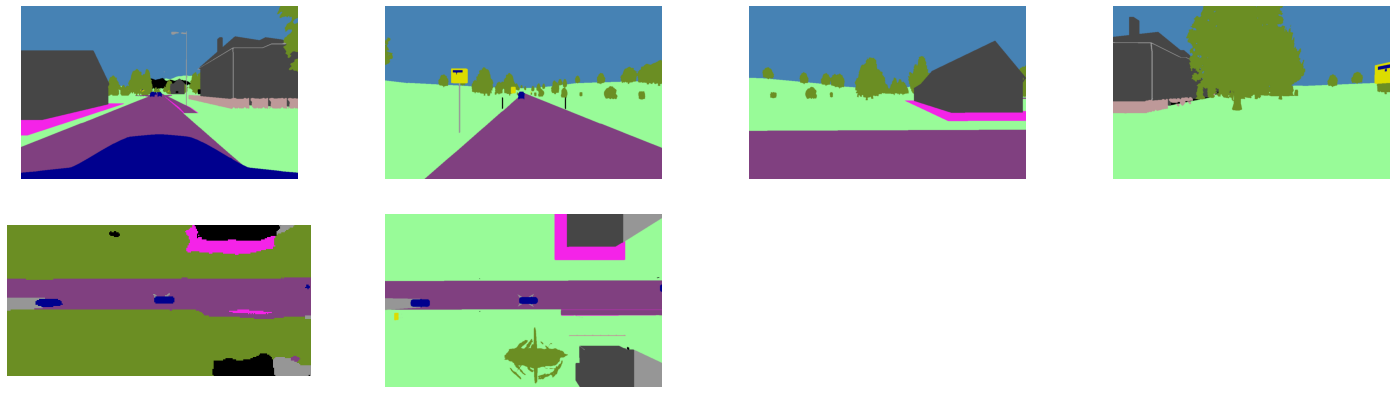

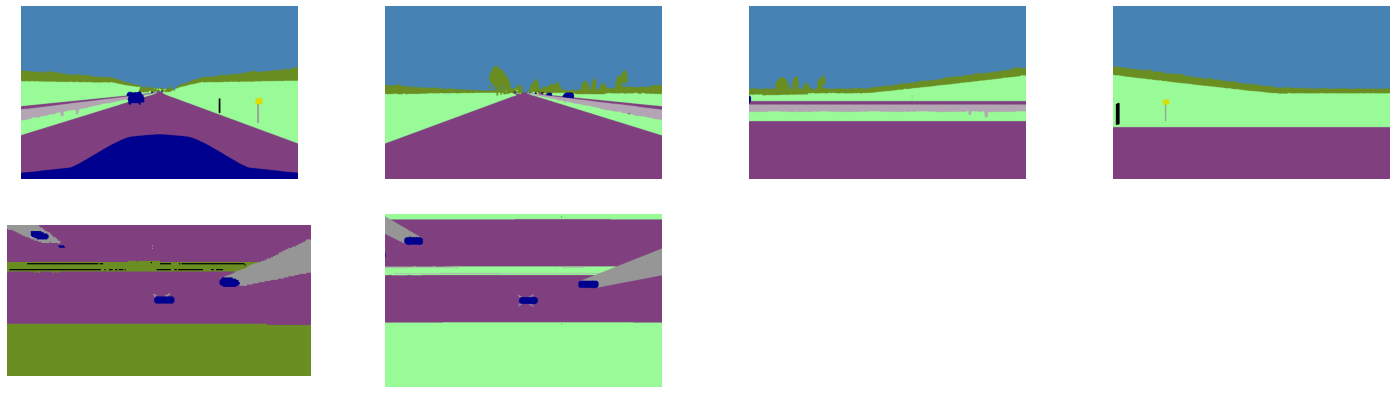

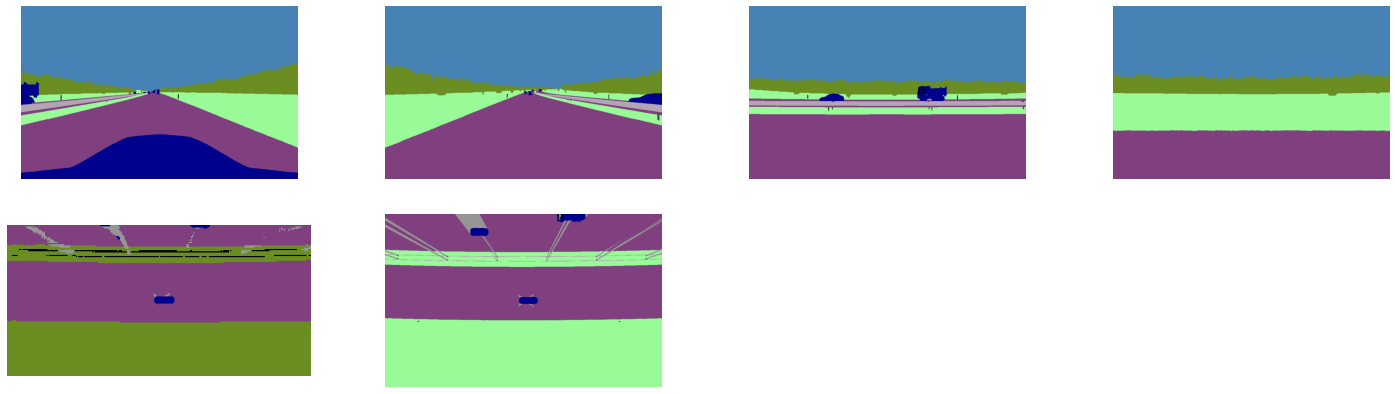

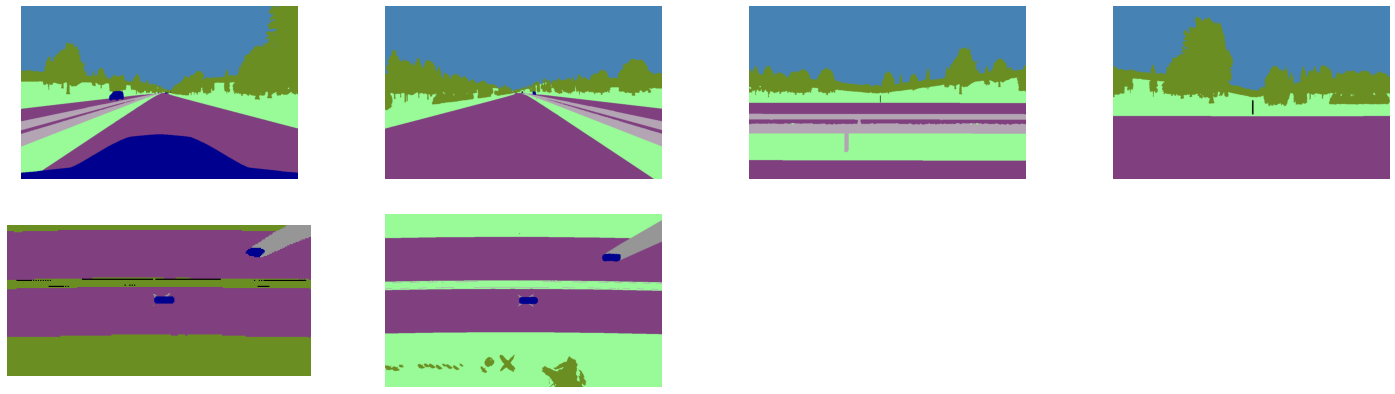

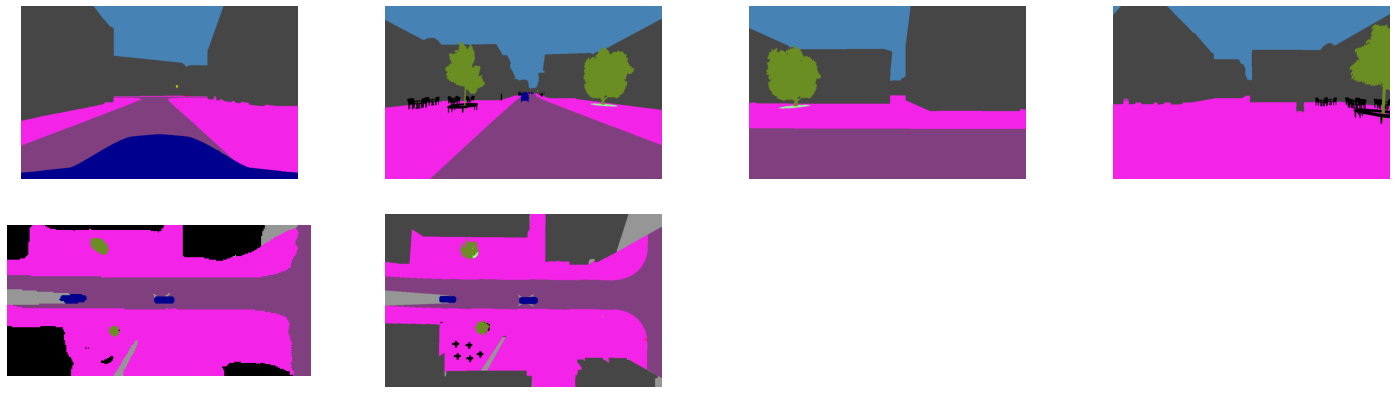

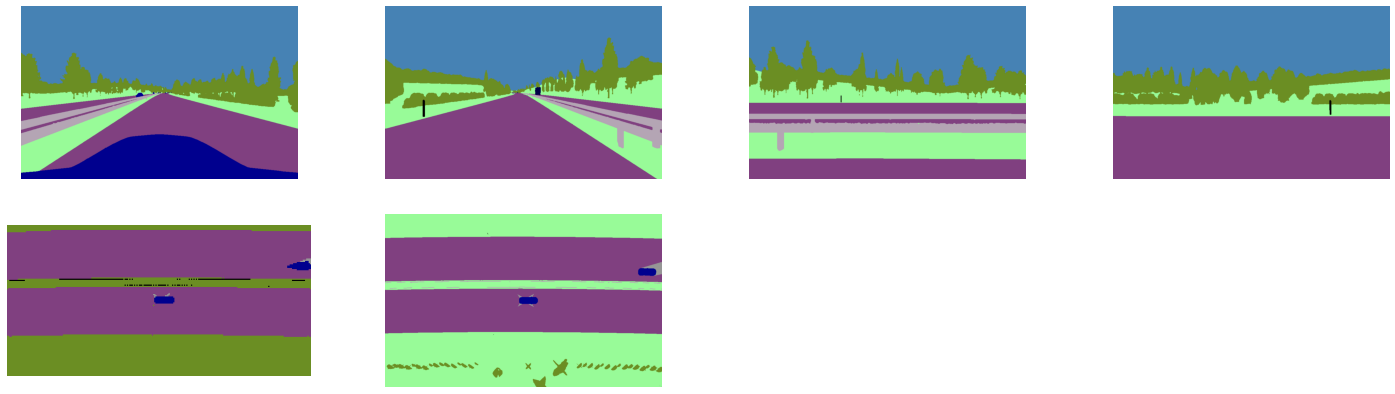

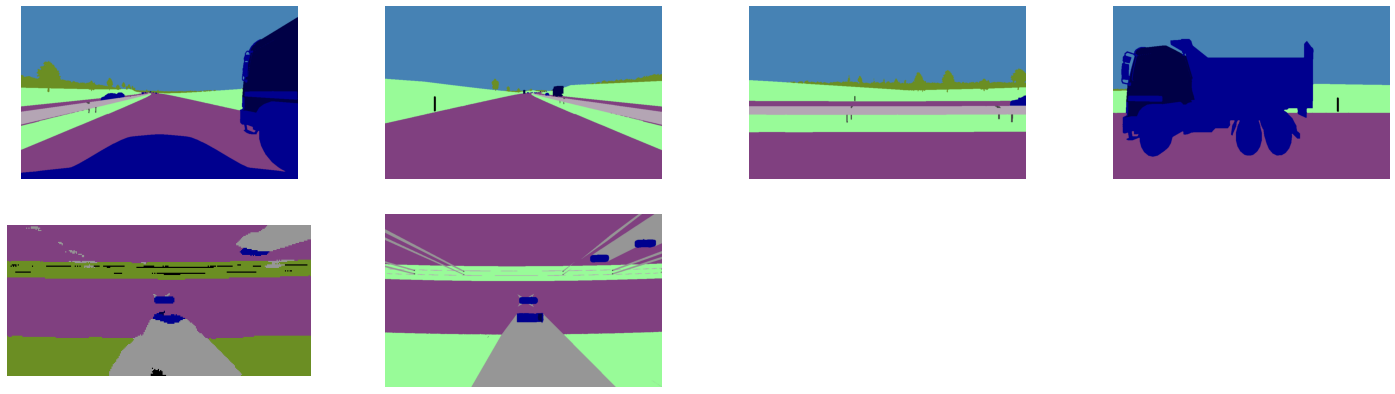

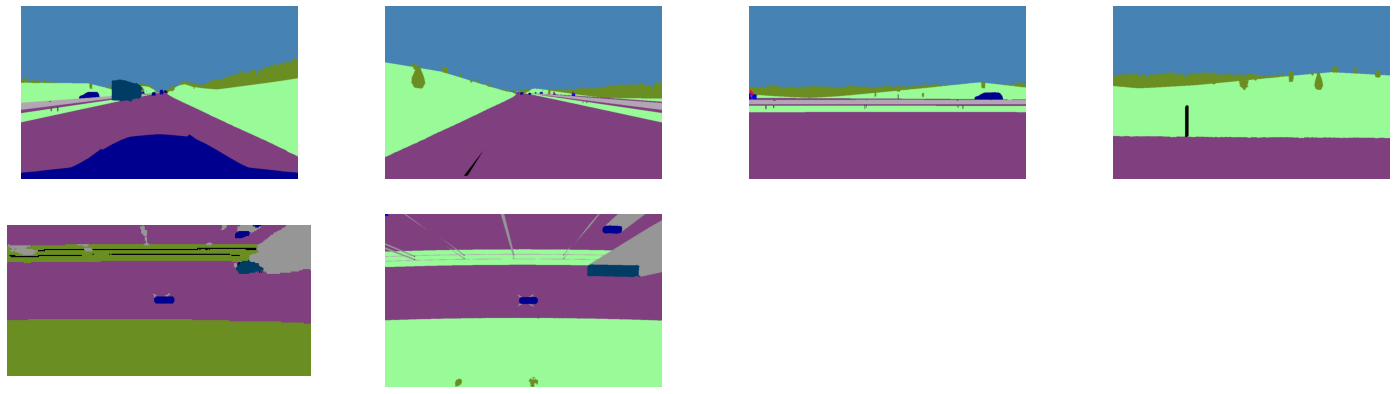

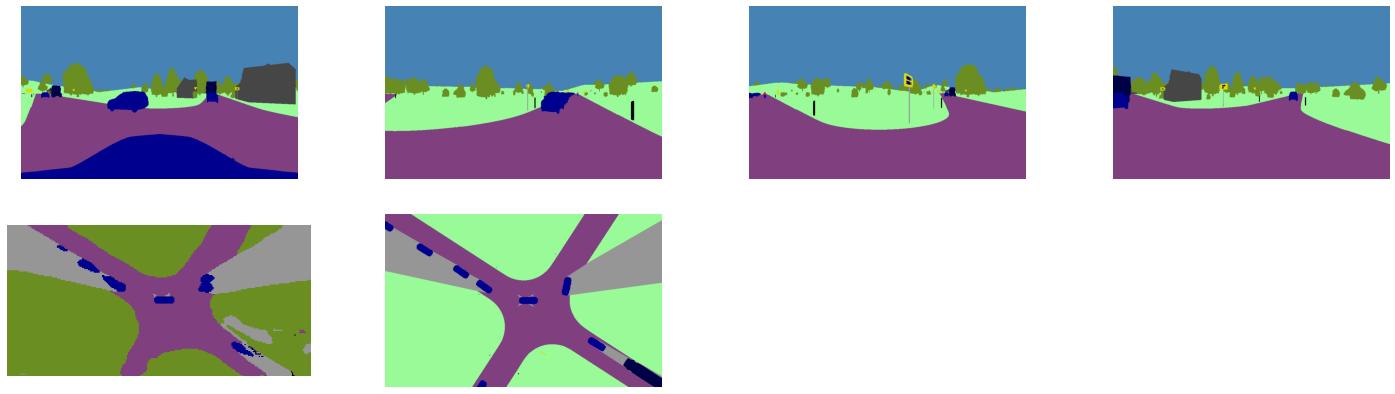

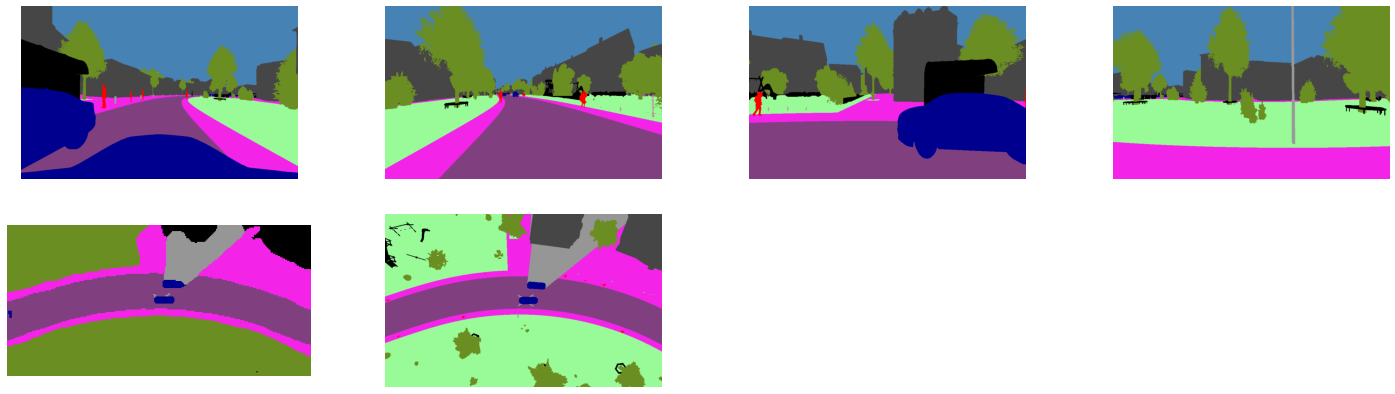

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

titles = ["Front", "Rear", "Left", "Right", "BEV", "Actual BEV"]

# run predictions
print(f"Running predictions and writing to {conf.prediction_dir} ...")
for k in random.sample(range(n_samples), 10):

    input_files = [files_input[i][k] for i in range(n_inputs)]
    label_file = files_label[k]

    # load sample
    inputs = parse_sample(input_files)

    # add batch dim
    if n_inputs > 1:
        inputs = [np.expand_dims(i, axis=0) for i in inputs]
    else:
        inputs = np.expand_dims(inputs, axis=0)

    # run prediction
    prediction = model.predict(inputs).squeeze()

    # convert to output image
    prediction = one_hot_decode_image(prediction, conf.one_hot_palette_label)
    
    plt.figure(figsize=(25,7))
    plt.tight_layout()
    for i in range(n_inputs + 2):
        ax = plt.subplot(2, 4, i + 1)
        
        if i == n_inputs:
            img = prediction
        elif i == n_inputs + 1:
            img = load_image(label_file)
        else:
            img = load_image(input_files[i])
            
        plt.axis('off')
        plt.imshow(img)
        
    plt.show()
            
    # write to disk
    output_file = os.path.join(conf.prediction_dir, os.path.basename(files_input[0][k]))
    cv2.imwrite(output_file, cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR))